
# Predicting the VIX

This notebook:
1. Loads daily VIX history and builds a series `x = log(CLOSE)`.
2. Fits a **2D GMM** on pairs `(x_t, x_{t+1})`.
3. Builds the conditional model $p(x_{t+1}\mid x_t)$.
4. Plots the posterior mean function $\mathbb{E}[x_{t+1} \mid x_t]$.
5. Simulates multi-step scenarios by iteratively sampling from the conditional.


In [1]:

# Use Jupyter inline backend so figures render in HTML builds
import matplotlib
matplotlib.use('module://matplotlib_inline.backend_inline')

import os, io
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.mixture import GaussianMixture
from sklearn.preprocessing import StandardScaler

from cgmm import GMMConditioner, ConditionalGMMRegressor

VIX_URL = "https://cdn.cboe.com/api/global/us_indices/daily_prices/VIX_History.csv"
CANDIDATE_PATHS = [
    os.environ.get("VIX_CSV", ""),
    "data/VIX_History.csv",
    "docs/_static/VIX_History.csv",
]

def load_vix():
    for p in CANDIDATE_PATHS:
        if p and os.path.exists(p):
            df = pd.read_csv(p)
            print(f"Loaded local CSV: {p}")
            break
    else:
        # Only download if allowed (avoid on RTD)
        allow_net = os.environ.get("ALLOW_NET", "1") not in ("0","false","False")
        if os.environ.get("READTHEDOCS","") or not allow_net:
            raise FileNotFoundError(
                "VIX_History.csv not found locally and network disabled. "
                "Place it at docs/_static/VIX_History.csv or set VIX_CSV=/path/to/file."
            )
        import urllib.request
        print("Downloading VIX history ...")
        with urllib.request.urlopen(VIX_URL) as f:
            data = f.read()
        df = pd.read_csv(io.BytesIO(data))
        os.makedirs("data", exist_ok=True)
        df.to_csv("data/VIX_History.csv", index=False)
        print("Saved to data/VIX_History.csv")
    df = df.rename(columns=str.upper)
    df["DATE"] = pd.to_datetime(df["DATE"])
    df = df.sort_values("DATE").reset_index(drop=True)
    return df

df = load_vix()
df.head()


Loaded local CSV: data/VIX_History.csv


,DATE,OPEN,HIGH,LOW,CLOSE
0,1990-01-02,17.24,17.24,17.24,17.24
1,1990-01-03,18.19,18.19,18.19,18.19
2,1990-01-04,19.22,19.22,19.22,19.22
3,1990-01-05,20.11,20.11,20.11,20.11
4,1990-01-08,20.26,20.26,20.26,20.26


In [31]:

# Build x series and (x_t, x_{t+1}) pairs
x = np.log(df["CLOSE"].astype(float).to_numpy())
pairs = np.column_stack([x[:-1], x[1:] - x[:-1]]).astype(float)

K = 3
gmm = GaussianMixture(n_components=K, covariance_type="full", random_state=0).fit(pairs)

# Conditioner and regressor: X = first coord (x_t), y = second (x_{t+1})
cond = GMMConditioner(gmm, cond_idx=[0], reg_covar=1e-9).precompute()
reg  = ConditionalGMMRegressor(gmm, cond_idx=[0]).fit(X=np.zeros((1,1)))


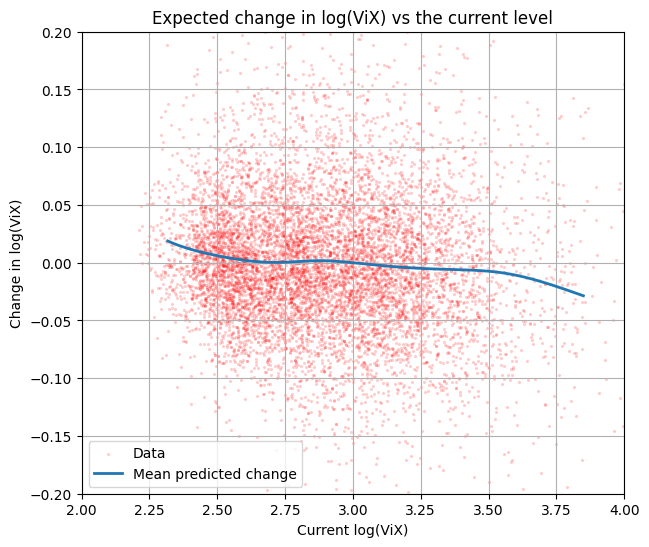

In [32]:

# Posterior mean mapping E[x_{t+1} | x_t]
fig, ax = plt.subplots(figsize=(7,6))

# Grid over original x_t coordinates
grid_xt = np.linspace(np.percentile(pairs[:,0], 1), np.percentile(pairs[:,0], 99), 200)

# conditional expectation on the grid
grid_xt_next = reg.predict(grid_xt[:, None]).ravel()


ax.scatter(pairs[:,0], pairs[:,1], s=5, alpha=0.2, linewidths=0, c='r', label="Data")
ax.plot(grid_xt, grid_xt_next, lw=2, label="Mean predicted change")


ax.set_xlim(2, 4)
ax.set_ylim(-0.2, 0.2)

ax.set_xlabel("Current log(ViX)")
ax.set_ylabel("Change in log(ViX)")
ax.set_title("Expected change in log(ViX) vs the current level")
ax.legend(loc="best")
ax.grid()
plt.show()


In [44]:
import numpy as np

def simulate_paths_delta(cond, x0, horizon=60, n_paths=100, seed=123):
    rng = np.random.default_rng(seed)
    xs = np.empty((n_paths, horizon + 1), dtype=float)

    for i in range(n_paths):
        xt = float(x0)
        xs[i, 0] = xt
        for t in range(horizon):
            gmmd = cond.condition([xt])  # posterior over Δ (1D GMM)
            gmmd.random_state = int(rng.integers(0, 2**32 - 1))
            y, _ = gmmd.sample(1)
            xt = xt + float(y[0, 0])     # x_{t+1} = x_t + Δ
            xs[i, t + 1] = xt
    return xs

# Run scenarios starting from last observed x
H, N = 60, 100
xs_paths = simulate_paths_delta(cond, x0=x[-1], horizon=H, n_paths=N)
vix_paths = np.exp(xs_paths)  # back to VIX level


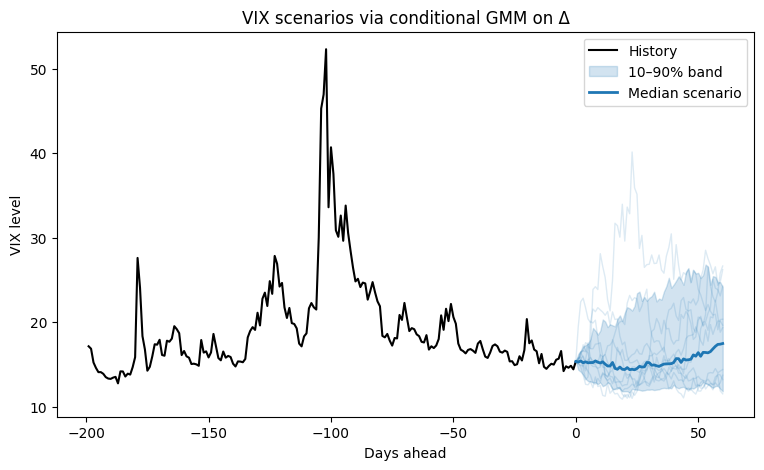

In [45]:
fig, ax = plt.subplots(figsize=(9,5))

hist_n = 200
ax.plot(np.arange(-hist_n+1, 1), np.exp(x[-hist_n:]),
        color="k", lw=1.5, label="History")

q = np.quantile(vix_paths, [0.1, 0.5, 0.9], axis=0)
t = np.arange(H+1)
ax.fill_between(t, q[0], q[2], color="tab:blue", alpha=0.2, label="10–90% band")
ax.plot(t, q[1], color="tab:blue", lw=2, label="Median scenario")

for i in range(min(10, N)):
    ax.plot(t, vix_paths[i], color="tab:blue", alpha=0.15, lw=1)

ax.set_xlabel("Days ahead")
ax.set_ylabel("VIX level")
ax.set_title("VIX scenarios via conditional GMM on Δ")
ax.legend()
plt.show()
